<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/report_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install pykalman 
!pip install arch

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pykalman import KalmanFilter
from statsmodels.tsa.ar_model import AR
import seaborn as sns
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr 
from statsmodels.tsa.arima_process import ArmaProcess
from arch import arch_model
import requests
sns.set()

# Constants

In [0]:
H = 6
V = 12

# GOLD CLOSE PRICE, 97 SUCCESSIVE TRADING DAYS

## Data

In [0]:
url='https://raw.githubusercontent.com/FinYang/tsdl/master/data-raw/commod/gold.dat'
s = requests.get(url).content
data = ' '.join([l.strip() for l in s.decode('utf-8').split('\n')[1:]])
serie = pd.Series(
    data.split(' '),
    index=pd.date_range(start ='1-1-1997', end ='4-7-1997', freq ='D')
) 

## Plot Serie

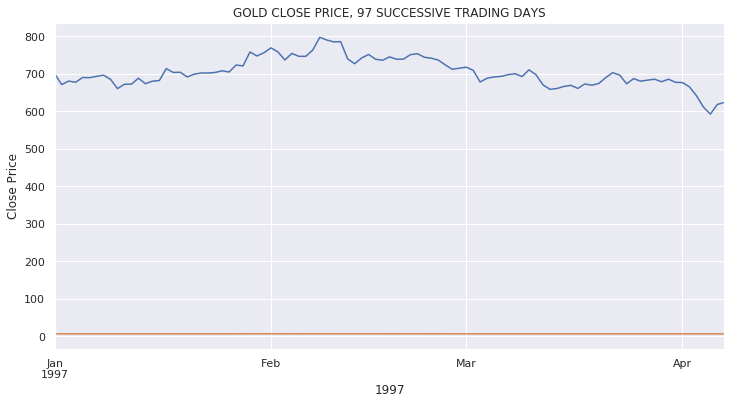

In [98]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.xlabel('1997')
plt.ylabel('Close Price')
plt.title('GOLD CLOSE PRICE, 97 SUCCESSIVE TRADING DAYS')
serie = np.log(serie)
serie.plot()

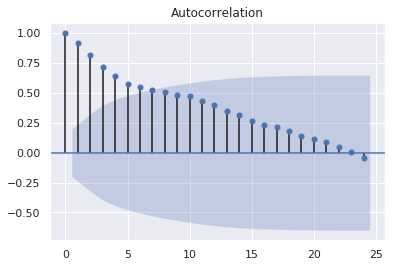

In [99]:
plot_acf(serie, lags=24)
plt.show()

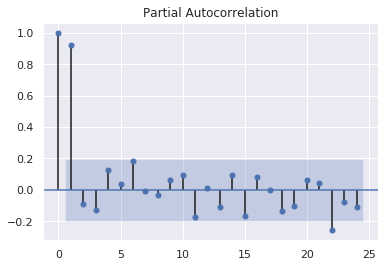

In [100]:
plot_pacf(serie, lags=24)
plt.show()

### Plot Diff

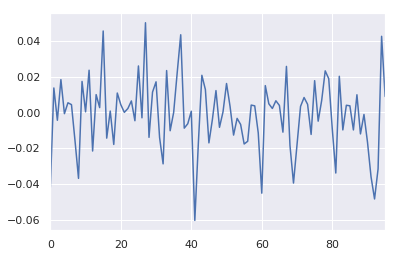

In [101]:
s_diff = np.diff(serie)
s_diff = pd.Series(s_diff)
s_diff.plot()

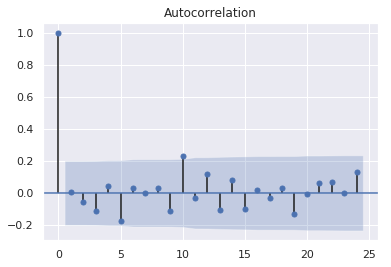

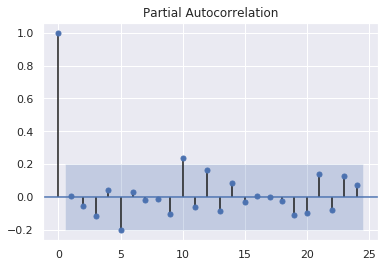

In [102]:
plot_acf(s_diff, lags=24)

plot_pacf(s_diff, lags=24)

plt.show()

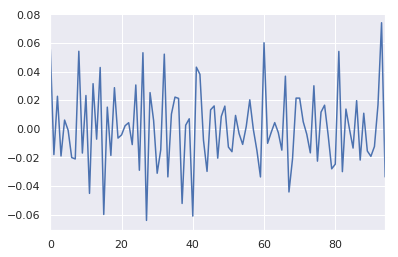

In [103]:
pd.Series(np.diff(s_diff)).plot()

## Seasonal decompose

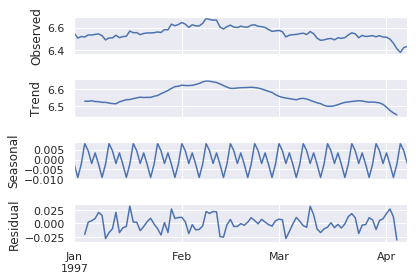

In [104]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

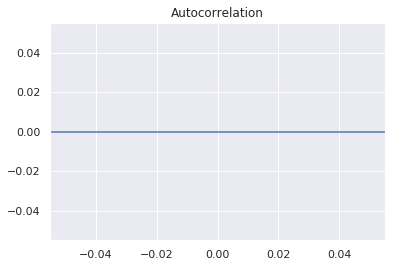

In [105]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [106]:
size = len(serie)
l = int((7*size)/10)
print(size, l)

# original serie
serie_train = serie[:l]
serie_test = serie[l:]

size = len(s_diff)
l = int((7*size)/10)
print(size, l)

# diff serie
s_diff_train = s_diff[:l]
s_diff_test = s_diff[l:]

97 67
96 67


## Models

### Holt-Winters

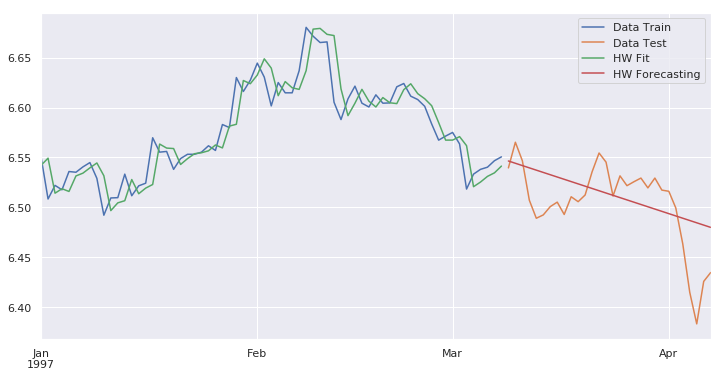

In [107]:
plt.figure(figsize=(V,H))

# fit the data
hw = Holt(serie_train).fit(smoothing_level=0.8, smoothing_slope=0.09)

# original serie
serie_train.plot(label='Data Train')

# original serie
serie_test.plot(label='Data Test')

# plot the data
hw.fittedvalues.plot(label='HW Fit')

# predict
predict = hw.predict(start=serie_test.index[0], end=serie_test.index[-1])
predict.plot(label='HW Forecasting')

# to show the plot
# hw.forecast(25).rename('HW Forecasting').plot()
plt.legend()
plt.show()

In [108]:
from sklearn.metrics import mean_squared_error
print('MSE Train = ', mean_squared_error(serie_train, hw.fittedvalues))
print('MSE Test = ', mean_squared_error(serie_test, predict))

MSE Train =  0.00038809451995372576
MSE Test =  0.0012423134145489363


### AR

In [109]:
# train AR
model = AR(serie_train)
model_fitted = model.fit(maxlag=3)

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  3
parameters:  const    0.615202
L1.y     0.865616
L2.y     0.045691
L3.y    -0.004755
dtype: float64


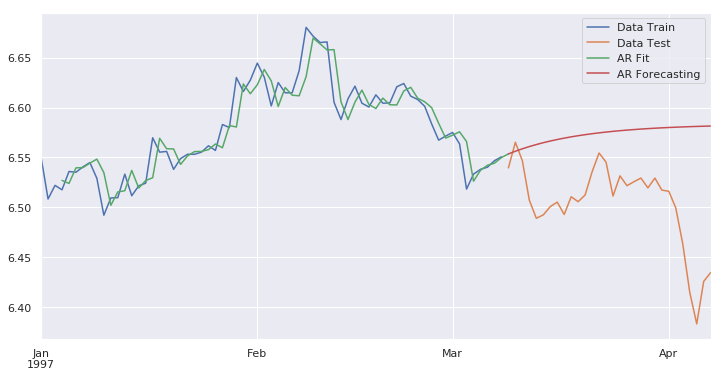

In [110]:
plt.figure(figsize=(V,H))

# plot data train and test
serie_train.plot(label='Data Train')

serie_test.plot(label='Data Test')

predict_train = model_fitted.predict(start=model_fitted.k_ar, end=len(serie_train), dynamic=False)
predict_train.plot(label='AR Fit')

predict = model_fitted.predict(start=serie_test.index[0], end=serie_test.index[-1], dynamic=False)
predict.plot(label='AR Forecasting')

#to show
plt.legend()
plt.show()

In [111]:
# print("MSE AR Train= ", mean_squared_error(serie_train, model_fitted.fittedvalues))
print("MSE AR Test = ", mean_squared_error(serie_test, predict))

MSE AR Test =  0.006773324692755296


### ARMA

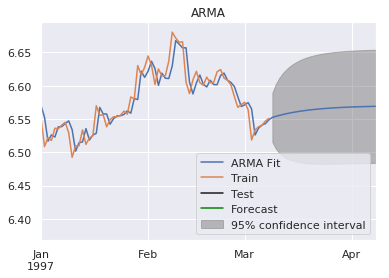

In [112]:
# ARMA(p,q) = ARIMA(p,0,q)
model_arma = ARIMA(serie_train, order=(1, 0, 1))  
fitted_arma = model_arma.fit(disp=0)  
# Forecast
fc_arma, se_arma, conf_arma = fitted_arma.forecast(len(serie_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_arma = pd.Series(fc_arma, index=serie_test.index)
arma_fittedValues = fitted_arma.fittedvalues

# Plot
fitted_arma.plot_predict(dynamic=False, end=len(serie_train) + len(serie_test))
plt.plot(serie_test, label="Test", color="k")
plt.plot(fc_series_arma, label='Forecast',color="green")
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
plt.title("ARMA")
L=plt.legend(loc='best')
L.get_texts()[0].set_text('ARMA Fit')
L.get_texts()[1].set_text('Train')
plt.show()

In [113]:
# MSE
mse_ar_train = mean_squared_error(serie_train, arma_fittedValues)
mse_ar = mean_squared_error(serie_test, fc_arma)

print("MSE AR Train= ", mse_ar_train)
print("MSE AR Test = ", mse_ar)

MSE AR Train=  0.00035851837776937356
MSE AR Test =  0.005422258991892225


### ARIMA

In [114]:
# train ARIMA
model = ARIMA(serie_train, order=(1, 1, 1))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  1
parameters:  const        0.000046
ar.L1.D.y   -0.992062
ma.L1.D.y    0.948299
dtype: float64


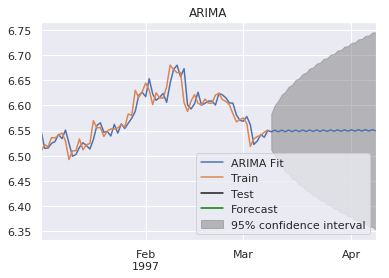

In [115]:
# Forecast
fc, se, conf = model_fitted.forecast(len(serie_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=serie_test.index)
arima_fittedValues = model_fitted.fittedvalues

# Plot
model_fitted.plot_predict(dynamic=False, start=1, end=len(serie_train)+len(serie_test))
plt.plot(serie_test, label="Test", color="k")
plt.plot(fc_series, label='Forecast',color="green")
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
plt.title("ARIMA")
L=plt.legend(loc='best')
L.get_texts()[0].set_text('ARIMA Fit')
L.get_texts()[1].set_text('Train')
plt.show()


In [116]:
# MSE
print("MSE ARIMA Train (on returns)= ", mean_squared_error(serie_train[1:], arima_fittedValues))
print("MSE ARIMA Test= ", mean_squared_error(serie_test, fc_series))

MSE ARIMA Train (on returns)=  43.25664530888494
MSE ARIMA Test=  0.0037899524545544562


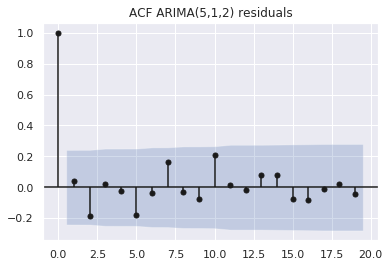

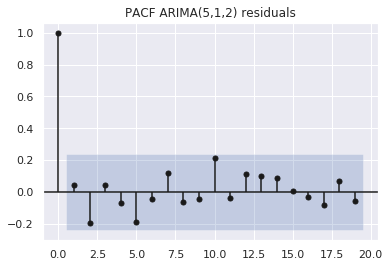

In [117]:
#plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
# plt.plot(residuals)
# plt.show()
plot_acf(residuals,color="k")
plt.title("ACF ARIMA(5,1,2) residuals")
plt.show()
plot_pacf(residuals,color="k")
plt.title("PACF ARIMA(5,1,2) residuals")
plt.show()

### GARCH

In [118]:
from arch import arch_model

am = arch_model(serie_train, mean='Zero', vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 221.26312750859935
Iteration:      2,   Func. Count:     13,   Neg. LLF: 221.2631258935903
Iteration:      3,   Func. Count:     18,   Neg. LLF: 221.2631212251382
Iteration:      4,   Func. Count:     23,   Neg. LLF: 221.26309914959003
Iteration:      5,   Func. Count:     28,   Neg. LLF: 221.263013456437
Iteration:      6,   Func. Count:     33,   Neg. LLF: 221.2628644987337
Iteration:      7,   Func. Count:     38,   Neg. LLF: 221.26278416089698
Iteration:      8,   Func. Count:     43,   Neg. LLF: 221.2627180823929
Iteration:      9,   Func. Count:     48,   Neg. LLF: 221.26268659801127
Iteration:     10,   Func. Count:     53,   Neg. LLF: 221.2626794217657
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 221.26267942182412
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results            

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


In [119]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 1
o_ = 1
q_ = 1

# Using student T distribution usually provides better fit
am = arch_model(s_diff, mean='Zero', vol='GARCH', p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.010
Vol Model:                        GJR-GARCH   Log-Likelihood:                243.693
Distribution:      Standardized Student's t   AIC:                          -477.385
Method:                  Maximum Likelihood   BIC:                          -464.564
                                              No. Observations:                   96
Date:                      Wed, Oct 09 2019   Df Residuals:                       91
Time:                              02:05:52   Df Model:                            5
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003967. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


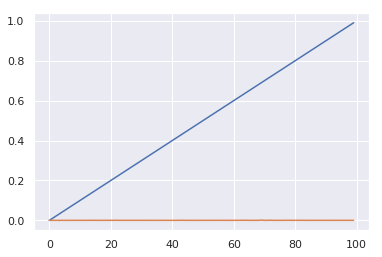

In [120]:
n_test = 100

# forecast the test set
yhat = am.forecast(horizon=n_test, method='simulation', simulations=5, params=res.params)

# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n_test:])

# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


<bound method ARCHModelResult.summary of                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                169.593
Distribution:                  Normal   AIC:                          -329.186
Method:            Maximum Likelihood   BIC:                          -318.163
                                        No. Observations:                   67
Date:                Wed, Oct 09 2019   Df Residuals:                       62
Time:                        02:06:01   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         

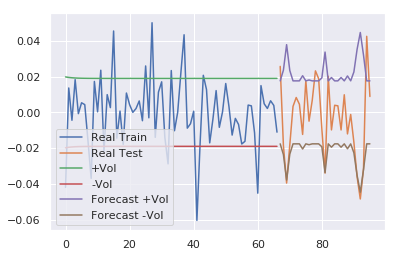

In [121]:
# training a Garch model
garch = arch_model(s_diff_train, vol='GARCH', p=p_, o=o_, q=q_ ).fit( disp='off')

# printing the statisticals
print(garch.summary)

forecasts = res.forecast(start=s_diff_test.index[0], method='simulation')

# plotting the modelling
plt.plot(s_diff_train, label='Real Train')
plt.plot(s_diff_test, label='Real Test')
plt.plot(garch._volatility, label = '+Vol')
plt.plot(-garch._volatility, label = '-Vol')
plt.plot(np.sqrt(forecasts.variance[l:]), label = 'Forecast +Vol')
plt.plot(-np.sqrt(forecasts.variance[l:]), label = 'Forecast -Vol')
plt.legend(loc='best')
plt.show()

### KALMAN

In [0]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 3.713572,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.85)

# Use the observed values
state_means, _ = kf.filter(serie_train)
state_means = pd.Series(state_means.flatten(), index=serie_train.index)

# Compute the rolling mean with various lookback windows
mean5 = pd.Series(serie_train).rolling(window=5).mean()
mean10 = pd.Series(serie_train).rolling(window=10).mean()

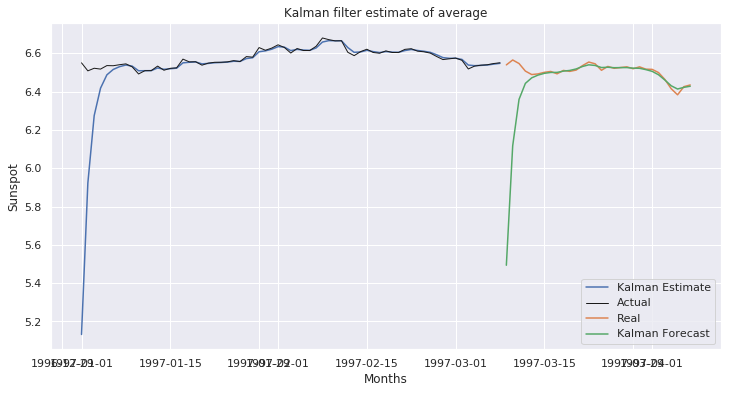

In [123]:
plt.figure(figsize=(V,H))

kalman_forecast = pd.Series([i[0] for i in kf.smooth(serie_test)[0]], index=serie_test.index)

# Plot original data and estimated mean
plt.plot(state_means, label="Kalman Estimate")
plt.plot(serie_train, label="Actual",color="k", linewidth=1)
#plt.plot(mean5, label="5W moving average")
#plt.plot(mean10, label="10W moving average")
plt.plot(serie_test, label="Real")
plt.plot(kalman_forecast, label="Kalman Forecast")
plt.title('Kalman filter estimate of average')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Sunspot')
plt.show()

In [124]:
 mse_kalman = mean_squared_error(serie_train, state_means)
print("MSE KALMAN = ", mse_kalman)
print("MSE KALMAN Test = ", mean_squared_error(serie_test, kalman_forecast))

MSE KALMAN =  0.036312265290273295
MSE KALMAN Test =  0.044572208631393745
